## Data Cleaning

Using a test run dataset, I show how json data was extracted and converted into read dataframes

In [3]:
import json
import pandas as pd

In [2]:
with open('data/test-run.json', 'r') as file:
    data = json.load(file)

In [3]:
data

[{'number_of_runs': 2, 'number_of_simulation_iterations': 500},
 {'final_bankroll': 70,
  'rounds_played': 5,
  'initial_bankroll': 100,
  'round_outcomes': [5, -5, -5, -5, 5]},
 {'final_bankroll': 50,
  'rounds_played': 5,
  'initial_bankroll': 100,
  'round_outcomes': [-5, -5, -5, -5, -5]}]

In [4]:
df = pd.read_json('data/test-run.json')
df

,number_of_runs,number_of_simulation_iterations,final_bankroll,rounds_played,initial_bankroll,round_outcomes
0,2.0,500.0,NaN,NaN,NaN,NaN
1,NaN,NaN,70.0,5.0,100.0,"[5, -5, -5, -5, 5]"
2,NaN,NaN,50.0,5.0,100.0,"[-5, -5, -5, -5, -5]"


In [5]:
metadata = df[['number_of_runs', 'number_of_simulation_iterations']].dropna()
metadata

,number_of_runs,number_of_simulation_iterations
0,2.0,500.0


In [6]:
final_results = df[['final_bankroll', 'rounds_played', 'initial_bankroll']].dropna()
final_results

,final_bankroll,rounds_played,initial_bankroll
1,70.0,5.0,100.0
2,50.0,5.0,100.0


In [7]:
game_data = df[['round_outcomes']].dropna().reset_index(names='game')
game_data = game_data.explode('round_outcomes').reset_index(names='round')

game_data


,round,game,round_outcomes
0,0,1,5
1,0,1,-5
2,0,1,-5
3,0,1,-5
4,0,1,5
5,1,2,-5
6,1,2,-5
7,1,2,-5
8,1,2,-5
9,1,2,-5


## Exploratory Analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [10]:
df = pd.read_json('data/test-run-5.json')

metadata = df[['number_of_runs', 'number_of_simulation_iterations']].dropna()

final_results = df[['final_bankroll', 'rounds_played', 'initial_bankroll']].dropna()

game_data = df[['round_outcomes']].dropna().reset_index(names='game')
game_data = game_data.explode('round_outcomes').reset_index(names='round')

## Visualization

In [71]:
with open("misc/MCTS_example_data/mcts_tree_2.json", "r") as f:
    data = json.load(f)

# Flatten into a DataFrame
rows = []
for node in data:
    rows.append({
        "id": node["id"],
        "parent_id": node["parent_id"],
        "action": node["action_history"][-1] if node["action_history"] else "ROOT",
        "hand": "-".join(node["agent_hand"][0]),
        "value": node["value"],
        "visits": node["visits"],
        "best_action": node["best_action"],
        "hit_uct": node['uct_values'].get('hit') if node['uct_values'].get('hit') else None,
        "stand_uct": node['uct_values'].get('stand') if node['uct_values'].get('stand') else None,
        "split_uct": node['uct_values'].get('split') if node['uct_values'].get('split') else None,
        "split_uct": node['uct_values'].get('double') if node['uct_values'].get('double') else None
            })
        
        # "stand_uct": [i for i in node['uct_values']['stand'] if node['action_history'][-1] == 'stand' else None,
        # "double_uct": node['uct_values']['double'] if node['action_history'][-1] == 'double' else None,
        # "split_uct": node['uct_values']['split'] if node['action_history'][-1] == 'split' else None,

df = pd.DataFrame(rows)
df
#df.to_csv("mcts_tree_flat.csv", index=False)

,id,parent_id,action,hand,value,visits,best_action,hit_uct,stand_uct,split_uct
0,0,NaN,ROOT,8-K,92,100,stand,1.137236,1.310103,1.137236
1,1,0.0,stand,8-K,96,96,None,NaN,NaN,NaN
2,2,0.0,hit,8-K-J,-2,2,None,NaN,NaN,NaN
3,3,2.0,hit,8-K-J-6,-1,1,None,NaN,NaN,NaN
4,4,0.0,double,8-K-J,-2,2,None,NaN,NaN,NaN


In [68]:
for node in data:
    print(type(node['uct_values']))
    print(node['uct_values'])
    print(node['uct_values'].get('hit') )#if node["action_history"][-1] is not None else None)
    


<class 'dict'>
{'stand': 1.3101028314005836, 'hit': 1.137236273093429, 'double': 1.137236273093429}
1.137236273093429
<class 'dict'>
{}
None
<class 'dict'>
{}
None
<class 'dict'>
{}
None
<class 'dict'>
{}
None


In [4]:
df

,id,parent_id,action,hand,value,visits,best_action
0,0,NaN,ROOT,8-K,92,100,stand
1,1,0.0,stand,8-K,96,96,None
2,2,0.0,hit,8-K-J,-2,2,None
3,3,2.0,hit,8-K-J-6,-1,1,None
4,4,0.0,double,8-K-J,-2,2,None


In [13]:
for i in data:
    print(i['uct_values']['hit'])

-0.473848801139635
-0.3408619888942307
-0.11261349710150803


KeyError: 'hit'

### Decision Tree Graph

In [4]:
with open("misc/mcts_tree_3.json", "r") as f:
    data = json.load(f)

# Flatten into a DataFrame
rows = []
for node in data:
    rows.append({
        "id": node["id"],
        "parent_id": node["parent_id"],
        "action": node["action_history"][-1] if node["action_history"] else "ROOT",
        "hand": "-".join(node["agent_hand"][0]),
        "value": node["value"],
        "visits": node["visits"],
        "best_action": node["best_action"]
    })

dataset = pd.DataFrame(rows)
#dataset.to_csv("mcts_tree_flat.csv", index=False)

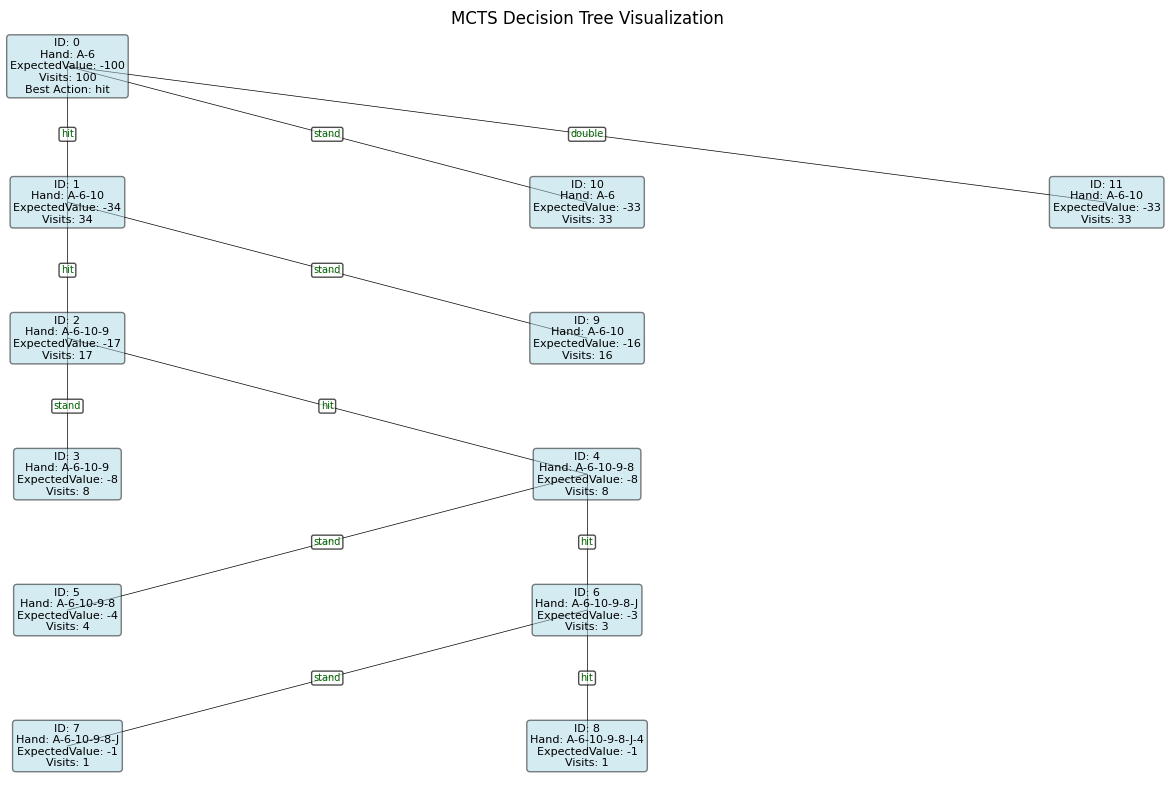

In [5]:
dataset['parent_id'] = dataset['parent_id'].fillna(-1).astype(int)
dataset['id'] = dataset['id'].astype(int)

node_info = dataset.set_index('id').T.to_dict()
# Define parent and child nodes
children = {}
root_id = None
for _, row in dataset.iterrows():
    node_id = row['id']
    parent_id = row['parent_id']
    if parent_id == -1:
        root_id = node_id
    else:
        children.setdefault(parent_id, []).append(node_id)

pos = {}
levels = {}
queue = [(root_id, 0)]
visited = set()

while queue:
    current_node, level = queue.pop(0)
    if current_node in visited:
        continue
    visited.add(current_node)
    levels[current_node] = level
    for child in children.get(current_node, []):
        queue.append((child, level + 1))

# Count how many nodes are at each level
level_widths = {}
for node_id, level in levels.items():
    level_widths[level] = level_widths.get(level, 0) + 1

level_x_positions = {level: 0 for level in sorted(level_widths)}

sorted_nodes = sorted(levels.items(), key=lambda x: (x[1], x[0]))
y_spacing = -1
x_spacing = 1.5
# set x, y position for each node
for node_id, level in sorted_nodes:
    x = level_x_positions[level] * x_spacing
    y = level * y_spacing
    pos[node_id] = (x, y)
    level_x_positions[level] += 1

center_offset = (max(level_widths.values()) - 1) * x_spacing / 2
for node_id in pos:
    x, y = pos[node_id]
    pos[node_id] = (x - center_offset, y)

fig, ax = plt.subplots(figsize=(12, 8))

# Draw edges 
for parent_id, child_list in children.items():
    if parent_id in pos:
        parent_pos = pos[parent_id]
        for child_id in child_list:
            if child_id in pos:
                child_pos = pos[child_id]
                ax.plot([parent_pos[0], child_pos[0]], [parent_pos[1], child_pos[1]], 'k-', linewidth=0.5)

# Create node labels (ID, value, visits, etc.)
for node_id, position in pos.items():
    info = node_info.get(node_id, {})
    label = f"ID: {node_id}\nHand: {info.get('hand', 'N/A')}\nExpectedValue: {info.get('value', 'N/A')}\nVisits: {info.get('visits', 'N/A')}"
    if pd.notna(info.get('best_action')):
        label += f"\nBest Action: {info.get('best_action', 'N/A')}"
    ax.text(position[0], position[1], label, fontsize=8, ha='center', va='center',
            bbox=dict(boxstyle='round,pad=0.3', fc='lightblue', alpha=0.5))

# Add action labels on edges
for parent_id, child_list in children.items():
    if parent_id in pos:
        parent_pos = pos[parent_id]
        for child_id in child_list:
            if child_id in pos:
                child_pos = pos[child_id]
                mid_x = (parent_pos[0] + child_pos[0]) / 2
                mid_y = (parent_pos[1] + child_pos[1]) / 2
                action = dataset[(dataset['id'] == child_id) & (dataset['parent_id'] == parent_id)].iloc[0]['action']
                ax.text(mid_x, mid_y, action, fontsize=7, ha='center', va='center', color='darkgreen',
                        bbox=dict(boxstyle='round,pad=0.2', fc='white', alpha=0.7))

ax.set_title('MCTS Decision Tree Visualization')
ax.axis('off')
ax.autoscale_view()
plt.tight_layout()
plt.show()
